In [606]:
import io
from pathlib import Path 
import zipfile

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize


from madigan.fleet.net.utils import calc_conv_out_shape, calc_pad_to_conserve

figsize(8, 8)

In [ ]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [ ]:
def load_and_aggregate_truefx(filepaths, timeframe='1h'):
    dfs = []
    for file in tqdm(filepaths):
        df = read_and_parse_truefx(file)
        df = df.resample(timeframe).last().dropna()
        dfs.append(df)
    return pd.concat(dfs)

In [536]:
files = list(datapath.iterdir())
files.sort()
print(len(files))

trn_df = load_and_aggregate_truefx(files[:50], '1min')
tst_df = load_and_aggregate_truefx(files[50: 60], '1min')

length:  1502256 
                          bid      ask
timestamp                            
2009-05-01 00:00:00  146.372  146.408
2009-05-01 00:01:00  146.380  146.425
2009-05-01 00:02:00  146.393  146.468
2009-05-01 00:03:00  146.410  146.472
2009-05-01 00:04:00  146.397  146.446
length:  302966 
                          bid      ask
timestamp                            
2013-07-01 00:00:00  151.189  151.239
2013-07-01 00:01:00  151.152  151.227
2013-07-01 00:02:00  151.115  151.184
2013-07-01 00:03:00  151.166  151.220
2013-07-01 00:04:00  151.209  151.245


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


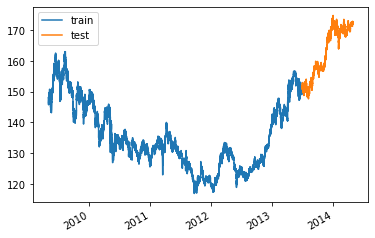

In [537]:
# %matplotlib notebook
%matplotlib inline
print('length: ', len(trn_df), '\n', trn_df.head())
print('length: ', len(tst_df), '\n', tst_df.head())
fig, ax = plt.subplots()
ax.plot(trn_df.mean(axis=1), label='train')
ax.plot(tst_df.mean(axis=1), label='test')
ax.legend()
fig.autofmt_xdate()

In [538]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.mean(axis=1)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.df[idx].to_numpy()

In [678]:
class FixedWindow(torch.utils.data.Dataset):
    def __init__(self, df, window_length):
        self.data = df.mean(axis=1).to_numpy().astype(np.float32)
#         self.data = df['C'].to_numpy().astype(np.float32)
        self.k = window_length
    def __len__(self):
        return len(self.data) - self.k
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            idx = slice(idx.start+self.k, idx.stop+self.k)
        else:
            idx = idx + self.k
        data = (self.data[idx - self.k: idx])
        return data, idx

In [679]:

class AE_MLP(nn.Module):
    """
        Symmetric - number of encoding layers == number of deconding layers
    """
    def __init__(self, input_size, encoded_size, d_model, n_encoding_layers):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        self.act_fn = nn.Tanh()
        bias = False
        layers = [nn.Linear(input_size, d_model, bias=bias), self.act_fn]
        for i in range(n_encoding_layers):
            layers.append(nn.Linear(d_model, d_model))
            layers.append(self.act_fn)
        self.encoder = nn.Sequential(*layers, nn.Linear(d_model, encoded_size, bias=bias))
        layers = [nn.Linear(encoded_size, d_model, bias=bias)]
        for i in range(n_encoding_layers):
            layers.append(nn.Linear(d_model, d_model, bias=bias))
            layers.append(self.act_fn)
        self.decoder = nn.Sequential(*layers, nn.Linear(d_model, input_size, bias=bias))        
        
    def forward(self, x):
#         with torch.no_grad():
#             norm = x[:, -1][..., None]
#             x = x / norm
        # NORMALIZE
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x = (x - mean) / std
        encoded = self.act_fn(self.encoder(x))
        decoded = self.decoder(encoded)
        # DENORMALIZE
        decoded = (decoded * std) + mean
        return decoded

In [680]:
from torch.nn.functional import relu, gelu

class AE_CNN_SYMM(nn.Module):
    """
        Symmetric - number of encoding layers == number of deconding layers
        all Conv1D layers have the same number of channels == d_model
        d_fc is the size of fc projection after the encoded bottleneck, 
        before passing on to Conv1dTranspose layers
    """
    def __init__(self, input_size, encoded_size, d_model, d_fc,
                 n_encoding_layers, dropout=0.1):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        self.d_model = d_model
        self.d_fc = d_fc
        self.dropout = dropout
        self.act = nn.GELU()
        
        bias = False
        layers = [nn.Conv1d(1, d_model, 5, bias=bias), self.act]
        for i in range(n_encoding_layers):
            layers.append(nn.Conv1d(d_model,  d_model, 5, bias=bias))
            layers.append(self.act)
#             layers.append(nn.BatchNorm1d(d_model))
            
        self.encoder_conv = nn.Sequential(*layers)
        out_shape = calc_conv_out_shape(input_size, layers)[0]
        self.encoder_fc = nn.Linear(out_shape*d_model, encoded_size, bias=bias)
        self.decoder_fc = nn.Linear(encoded_size, d_fc*out_shape, bias=bias)
        
        layers = [nn.ConvTranspose1d(d_fc, d_model, 5, bias=bias),
                 self.act]
        for i in range(n_encoding_layers-1):
            layers.append(nn.ConvTranspose1d(d_model, d_model, 5, bias=bias))
            layers.append(self.act)
#             layers.append(nn.BatchNorm1d(d_model))
        self.decoder_conv = nn.Sequential(*layers, nn.ConvTranspose1d(d_model, 1, 5, bias=bias))
        
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x = (x-mean) / std
        x = x[..., None].transpose(1, -1)
        x = self.encoder_conv(x).reshape(x.shape[0], -1)
        x = self.act(self.encoder_fc(x))
        x = self.act(self.decoder_fc(x))
        x = x.reshape(x.shape[0], self.d_fc, -1)
        x = self.decoder_conv(x)[:, 0, :]        
        return mean + (x * std)

In [740]:
class AE_CNN(nn.Module):
    """
    AutoEncoder using 1D convolutions
    After the bottleneck (of size encoded_size)
    """
    def __init__(self, input_size, encoder_channels,
                 encoded_size, d_fc, decoder_channels,
                 dropout=0.1):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        self.d_fc = d_fc
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()
        kernel_size = 5
        bias = False
        groups = 2
        
        encoder_channels = [1] + encoder_channels
        layers=[]
        for i in range(1, len(encoder_channels)):
            conv = nn.Conv1d(encoder_channels[i-1], encoder_channels[i],
                             kernel_size, bias=bias, groups=min(
                                 max(encoder_channels[i-1]//groups, 1), groups),
                             padding = (kernel_size-1)//2)
#             padding = calc_pad_to_conserve(input_size, conv, causal_dim=0)
#             print(padding)
#             layers.append(nn.ReplicationPad1d(padding = padding[0]//2))
#             layers.append(nn.ZeroPad1d(padding = padding[0]//2))
            layers.append(conv)
            layers.append(self.act)
            
        self.encoder_conv = nn.Sequential(*layers)
        
        out_sz = calc_conv_out_shape(input_size, layers)[0]
        self.encoder_fc = nn.Linear(out_sz*encoder_channels[-1],
                                    encoded_size, bias=bias)
        
        decoder_channels = [d_fc] + decoder_channels
        layers=[]
        for i in range(1, len(decoder_channels)):
            layers.append(nn.ConvTranspose1d(decoder_channels[i-1],
                                             decoder_channels[i], 
                                             5, groups=groups, bias=bias))
            layers.append(self.act)
            
        self.decoder_conv = nn.Sequential(
            *layers, nn.ConvTranspose1d(decoder_channels[-1], 1, 5, bias=bias))
        
        # decoder_fc is earlier in the call graph
        # but decoder_conv output is used to adaptively determine dec_sz
        # so is intialized after decoder_conv
        dec_sz = out_sz // 2 # reasonable starting value
        dummy_input = torch.randn(1, d_fc, dec_sz)
        while self.decoder_conv(dummy_input).shape[-1] < input_size:
            dec_sz += 1
            dummy_input = torch.randn(1, d_fc, dec_sz)
        self.decoder_fc = nn.Linear(encoded_size, d_fc*dec_sz, bias=bias)
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
#         mean = torch.zeros_like(x)
        std = x.std(-1, keepdim=True)
#         std = torch.ones_like(mean)
        x = (x-mean) / std
        x = x[..., None].transpose(1, -1)
        x = self.encoder_conv(x).reshape(x.shape[0], -1)
        x = self.act(self.encoder_fc(x))
        x = self.act(self.decoder_fc(x))
        x = self.dropout(x.reshape(x.shape[0], self.d_fc, -1))
        x = self.decoder_conv(x)[:, 0, :]        
        return mean + (x * std)

In [741]:
def model_size(model):
     return reduce(lambda x,y:x+y,
                   [reduce(lambda x,y:x+y, p.shape)
                    for p in model.parameters()])

In [742]:
def trainer(model, dataloader, device, lr=1e-3):
    loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print_freq = max(len(dataloader) // 100, 100)
    model.train()
    for i, (x, idx) in enumerate(iter(dataloader)):
        opt.zero_grad()
        x = x.to(device)
        y = x
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
        _loss = loss.detach().item()
        yield _loss
        if i % print_freq == 0:
            print(_loss, end='\r', flush=True)
        
@torch.no_grad()
def test(model, dataloader, device):
    loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    losses = []
    xs = []
    preds = []
    model.eval()
    for i, (x, idx) in enumerate(iter(dataloader)):
        x = x.to(device)
        y = x
        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss.detach().item())
        xs.append(x.cpu().numpy())
        preds.append(pred.cpu().numpy())
    return {'loss': losses, 'x': xs, 'pred': preds}
        

In [743]:
def show_performance(metrics, accumulate_returns=False):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    axs = ax.flatten()
    for i, _ax in enumerate(axs):
        if accumulate_returns:
            dat_y = np.cumsum(metrics['x'][0][i])
            dat_pred = np.cumsum(metrics['pred'][0][i])
        else:
            dat_y = metrics['x'][0][i]
            dat_pred = metrics['pred'][0][i]
        _ax.plot(dat_y, label='y target')
        _ax.plot(dat_pred, label='pred')
        _ax.legend()
    return fig, ax


In [762]:
window_size = 64
batch_size = 64
d_model = 32
encoded_size = 8
d_fc = 32
encoder_channels = [32, 32]
decoder_channels = [64, 64, 64]
dropout = 0.2

trn_dset = FixedWindow(trn_df, window_size)
tst_dset = FixedWindow(tst_df, window_size)
trnloader = torch.utils.data.DataLoader(trn_dset, batch_size=batch_size, 
                                        shuffle=True)
tstloader = torch.utils.data.DataLoader(tst_dset, batch_size=batch_size, 
                                        shuffle=True)

# model = AE_MLP(input_size=window_size, encoded_size=16, d_model=64, n_encoding_layers=1).to(device)
# model = AE_CNN_SYMM(input_size=window_size, encoded_size=window_size//8,
#                     d_model=d_model, d_fc=d_fc, n_encoding_layers=1).to(device)
# model = AE_CNN_ASYMM(input_size=64, encoded_size=32, d_model=32, n_encoding_layers=4).to(device)
model = AE_CNN(window_size, encoder_channels, encoded_size, 
               d_fc, decoder_channels, dropout=dropout).to(device)
print('model size', model_size(model))
print('len of train dataset', len(trn_dset))
print('len of train dataloader', len(trnloader))

model size 4032
len of train dataset 1502192
len of train dataloader 23472


In [763]:
# Test forward pass

x = next(iter(trnloader))[0].to(device)
pred = model(x)
assert x.shape == pred.shape, print(pred.shape, x.shape)

In [764]:
losses = []

In [766]:
epochs = 4

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm(range(epochs)):
    train_loop = iter(trainer(model, trnloader, device))
    for loss in train_loop:
        losses.append(loss)
    

0.019635135307908058


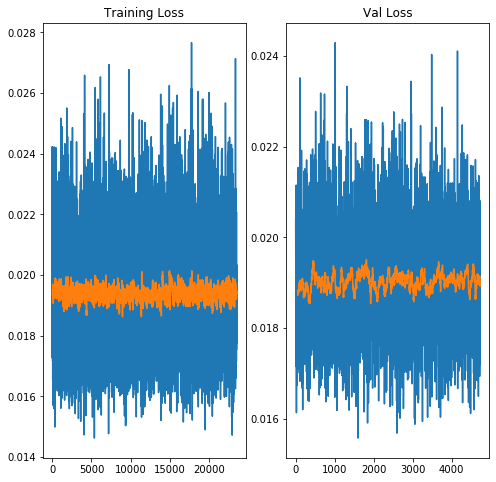

In [767]:
metrics = test(model, tstloader, device)

fig, ax = plt.subplots(1, 2)
ax[0].plot(losses[-len(trnloader)+10:])
ax[0].plot(pd.Series(losses[-len(trnloader)+10:]).rolling(50).mean(),
          label='running mean (50 period)')
ax[0].set_title('Training Loss')
ax[1].plot(metrics['loss'])
ax[1].plot(pd.Series(metrics['loss']).rolling(50).mean(),
          label='running mean (50 period)')
_ = ax[1].set_title('Val Loss')

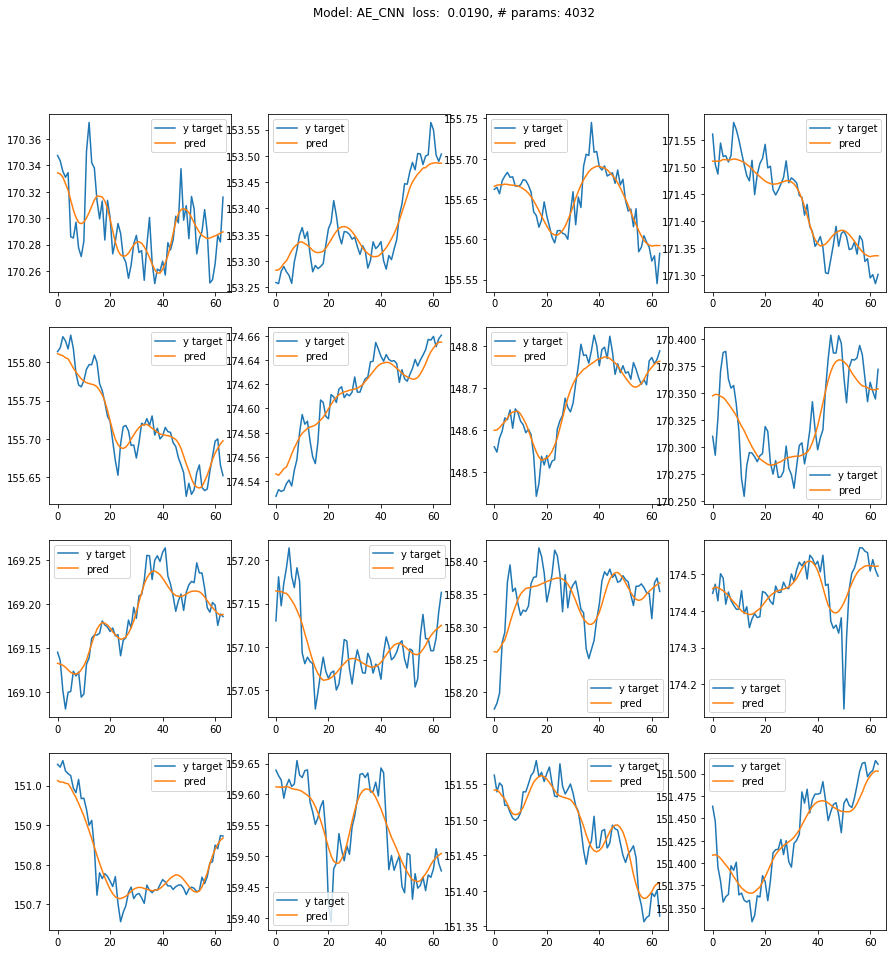

In [768]:
fig, ax = show_performance(metrics, accumulate_returns=False)
_ = fig.suptitle(f"Model: {type(model).__name__}  loss: {np.mean(metrics['loss']): .4f}, # params: {model_size(model)}")